In [1]:
!pip install git+https://github.com/openai/CLIP.git ftfy regex tqdm
!pip install torch torchvision Pillow

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-3_ebzp17
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-3_ebzp17
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.3 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=3efaa67ce6dfd9557bfe3b70bb9d3e577099c63fb3d89c26b4107cd44a1763a1
  Stored in directory: /tmp/pip-ephem-wheel-cache-mlz4qxrs/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip


In [2]:
import torch
import clip
from PIL import Image
from torchvision import transforms
import requests
from io import BytesIO


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on:", device)

model, preprocess = clip.load("ViT-B/32", device=device)

Running on: cuda


100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 189MiB/s]


In [4]:
# 📸 Step 4: Load your local images
# Example: if you uploaded them in Colab (via left panel or files.upload())
# Replace filenames below with your own image names

img_path1 = "/content/CLIP-1.png"
img_path2 = "/content/CLIP-2.png"

image1 = preprocess(Image.open(img_path1).convert("RGB")).unsqueeze(0).to(device)
image2 = preprocess(Image.open(img_path2).convert("RGB")).unsqueeze(0).to(device)


In [6]:
# Step 5: Encode both images using CLIP
with torch.no_grad():
    v1 = model.encode_image(image1)
    v2 = model.encode_image(image2)

# Normalize the embeddings
v1 /= v1.norm(dim=-1, keepdim=True)
v2 /= v2.norm(dim=-1, keepdim=True)

# Get semantic difference
diff = v2 - v1
diff /= diff.norm(dim=-1, keepdim=True)


In [7]:
# Step 6: Compare the difference with text concepts
concepts = ["cap", "hat", "helmet", "hair", "glasses", "beard", "shirt", "scarf"]

text_tokens = clip.tokenize(concepts).to(device)

with torch.no_grad():
    text_embeds = model.encode_text(text_tokens)

text_embeds /= text_embeds.norm(dim=-1, keepdim=True)

# Compute cosine similarity
similarity = (diff @ text_embeds.T).softmax(dim=-1)[0].cpu()

# 🧾 Display ranked results
for word, score in sorted(zip(concepts, similarity.tolist()), key=lambda x: x[1], reverse=True):
    print(f"{word:10s} → {score:.4f}")


hat        → 0.1348
cap        → 0.1318
helmet     → 0.1267
scarf      → 0.1239
beard      → 0.1219
shirt      → 0.1217
glasses    → 0.1203
hair       → 0.1187


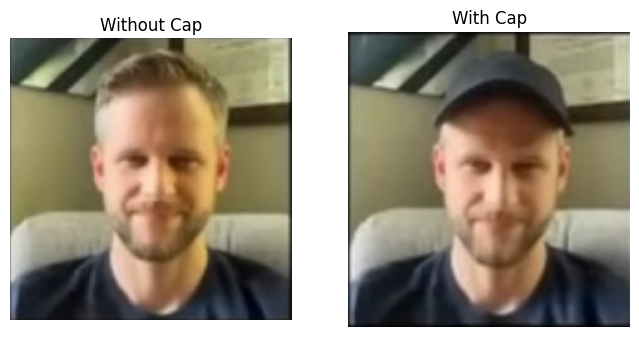

In [8]:
#  Step 7: Optional — Show both images side by side
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(8,4))
ax[0].imshow(Image.open(img_path1))
ax[0].set_title("Without Cap")
ax[0].axis("off")

ax[1].imshow(Image.open(img_path2))
ax[1].set_title("With Cap")
ax[1].axis("off")
plt.show()
